In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
import sys


# representative RGB colours for each label, for nice display
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 114, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'pink': (255, 187, 187),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])


def plot_predictions(model, lum=71, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution
    n_ticks = 5

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.suptitle('Predictions at L=%g' % (lum,))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.ylabel('B')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.imshow(pixels)

In [118]:
data = pd.read_csv("colour-data.csv")

In [119]:
data.head()

,R,G,B,Label,Confidence
0,168,211,243,blue,good
1,37,32,40,black,perfect
2,35,34,38,black,perfect
3,79,74,159,purple,good
4,55,99,34,green,perfect


In [120]:
X = (data[["R","G","B"]]/255).values
y = data.Label

In [121]:
X[:5]

array([[0.65882353, 0.82745098, 0.95294118],
       [0.14509804, 0.1254902 , 0.15686275],
       [0.1372549 , 0.13333333, 0.14901961],
       [0.30980392, 0.29019608, 0.62352941],
       [0.21568627, 0.38823529, 0.13333333]])

In [122]:
y

0         blue
1        black
2        black
3       purple
4        green
         ...  
3945     brown
3946      grey
3947      blue
3948     green
3949     green
Name: Label, Length: 3950, dtype: object

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1138)

In [125]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3160, 3)
(790, 3)
(3160,)
(790,)


In [126]:
from sklearn.linear_model import LogisticRegression

In [127]:
model_rgb = LogisticRegression()
model_rgb.fit(X_train, y_train)
model_rgb.score(X_test, y_test)

0.6772151898734177

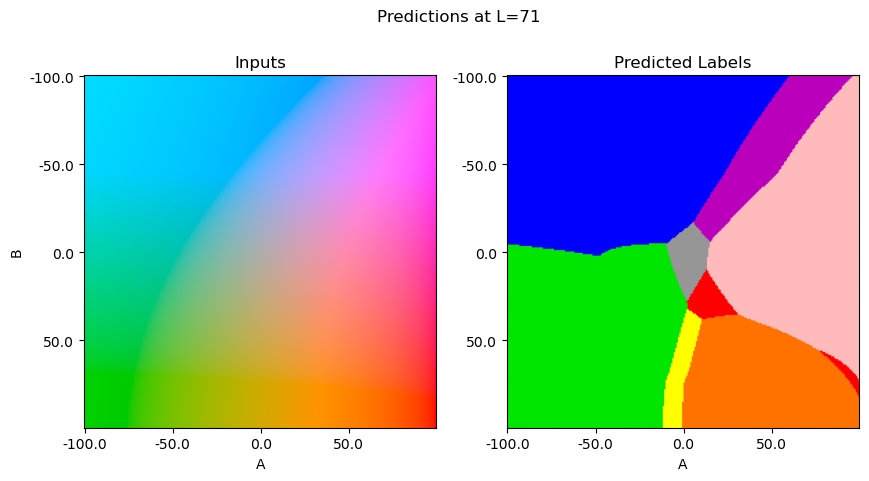

In [128]:
plot_predictions(model_rgb)

In [129]:
y_pred = model_rgb.predict(X_test)

In [130]:
from sklearn.metrics import classification_report

In [131]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       black       0.63      0.95      0.76        73
        blue       0.81      0.77      0.79       106
       brown       0.75      0.11      0.19        54
       green       0.70      0.90      0.79       155
        grey       0.64      0.56      0.60        84
      orange       0.82      0.47      0.60        30
        pink       0.59      0.65      0.62        62
      purple       0.74      0.83      0.78       124
         red       0.38      0.36      0.37        64
       white       0.00      0.00      0.00         9
      yellow       0.73      0.38      0.50        29

    accuracy                           0.68       790
   macro avg       0.62      0.54      0.55       790
weighted avg       0.68      0.68      0.65       790



C:\Users\dhurley\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dhurley\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dhurley\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [133]:
def makelab(X):
    X = X.reshape(1,-1,3)
    lab = rgb2lab(X)
    return lab.reshape(-1,3)

In [134]:
from skimage.color import rgb2lab

In [135]:
model_lab = make_pipeline(
    FunctionTransformer(makelab),
    LogisticRegression(max_iter=10000)
)

In [136]:
model_lab.fit(X_train, y_train)
print(model_lab.score(X_test, y_test))
y_pred = model_lab.predict(X_test)

0.710126582278481


Lab seems to be getting a better score, but we shouldn't really be using test scores to make choices, cross_validation scores should be used, see below

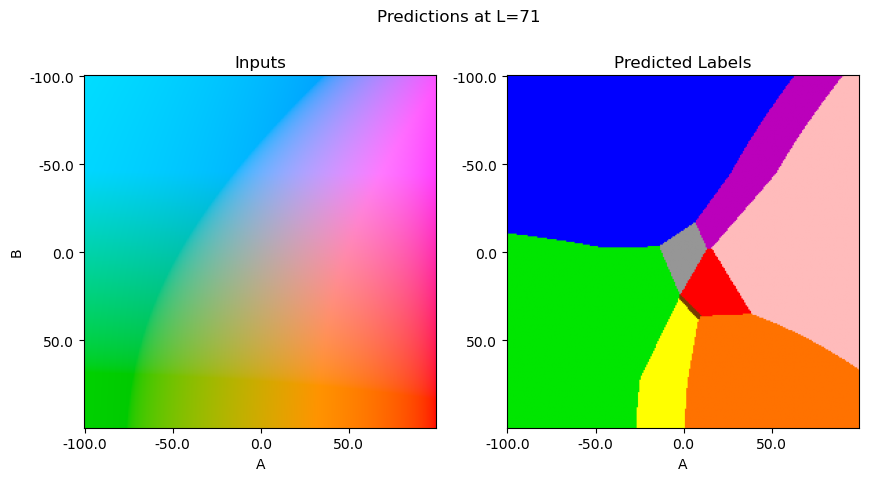

In [137]:
plot_predictions(model_lab)

Is predicting brown a bit more

## Cross Validation
Now I am going to try picking my C using cross validation. I will do this with both RGB and LAB and then pick the overall which gives me the best cross validation score

### First RGB

In [138]:
from sklearn.model_selection import cross_val_score

In [139]:
count = 0

In [140]:
Cvalues = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
count = 0
score = np.zeros(len(Cvalues))
for i in Cvalues:
    model = LogisticRegression(C=i, max_iter=10000)
    score[count] = cross_val_score(model, X_train, y_train).mean()
    count += 1

In [141]:
score

array([0.23101266, 0.23101266, 0.30791139, 0.55253165, 0.66012658,
       0.69873418, 0.70664557, 0.70632911, 0.70601266])

In [142]:
np.argmax(score)

6

In [143]:
Cvalues[6]

100

In [144]:
score[6]

0.7066455696202532

## RGB Result
So the best C value for RGB is C=100 with a cross_val average of 0.7066

### Now LAB cross val

In [145]:
Cvalues = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
count = 0
score = np.zeros(len(Cvalues))
for i in Cvalues:
    model = make_pipeline(
        FunctionTransformer(makelab),
        LogisticRegression(C=i, max_iter=10000)
    )
    score[count] = cross_val_score(model, X_train, y_train).mean()
    count += 1
    print(count)

1
2
3
4
5
6
7
8
9


In [146]:
score

array([0.67120253, 0.69240506, 0.69082278, 0.69113924, 0.69050633,
       0.69050633, 0.69082278, 0.69082278, 0.69018987])

In [147]:
np.argmax(score)

1

In [167]:
Cvalues[1]

0.001

In [148]:
score[1]

0.6924050632911392

## LAB
The best C value for LAB is C=0.001 with a cross_val average of 0.6924

## Best Model
By cross-validation the best model to pick is the RGB model with a C value of 100

In [149]:
best_model = LogisticRegression(C=100, max_iter=1000)

In [150]:
best_model.fit(X_train,y_train)

LogisticRegression(C=100, max_iter=1000)

In [151]:
best_model.score(X_test, y_test)

0.7215189873417721

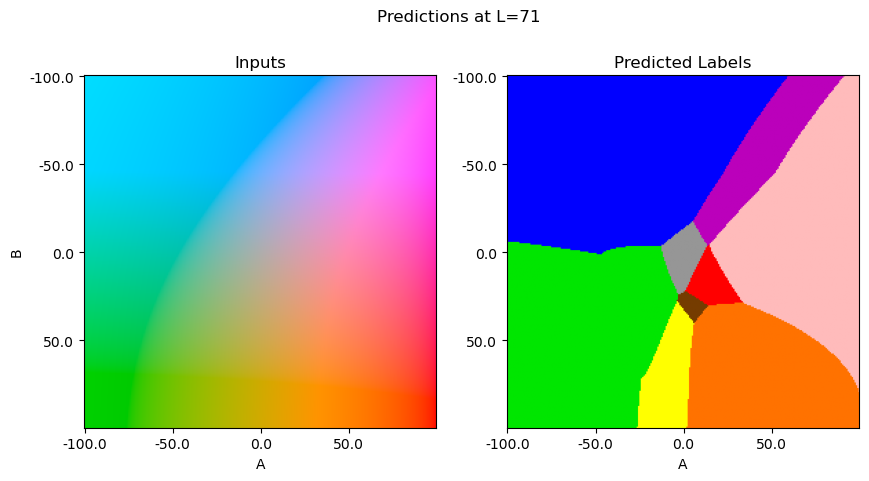

In [152]:
plot_predictions(best_model)

In [153]:
y_pred = best_model.predict(X_test)

In [154]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       black       0.73      0.93      0.82        73
        blue       0.81      0.79      0.80       106
       brown       0.69      0.33      0.45        54
       green       0.83      0.87      0.85       155
        grey       0.62      0.74      0.67        84
      orange       0.76      0.53      0.63        30
        pink       0.67      0.66      0.67        62
      purple       0.78      0.83      0.80       124
         red       0.39      0.41      0.40        64
       white       0.00      0.00      0.00         9
      yellow       0.71      0.59      0.64        29

    accuracy                           0.72       790
   macro avg       0.64      0.61      0.61       790
weighted avg       0.71      0.72      0.71       790



C:\Users\dhurley\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dhurley\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dhurley\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
from sklearn.metrics import confusion_matrix

In [156]:
confusion_matrix(y_test, y_pred)

array([[ 68,   0,   1,   0,   2,   0,   0,   1,   1,   0,   0],
       [  3,  84,   0,   4,   7,   0,   0,   8,   0,   0,   0],
       [  5,   0,  18,   4,   5,   1,   1,   0,  18,   0,   2],
       [  4,   4,   3, 135,   8,   0,   0,   0,   0,   0,   1],
       [  4,   4,   0,   7,  62,   1,   1,   2,   3,   0,   0],
       [  0,   0,   1,   2,   0,  16,   2,   0,   7,   0,   2],
       [  0,   0,   0,   0,   0,   0,  41,  15,   6,   0,   0],
       [  5,   5,   0,   1,   3,   0,   2, 103,   5,   0,   0],
       [  2,   6,   1,   6,   5,   3,  10,   3,  26,   0,   2],
       [  2,   0,   1,   0,   4,   0,   2,   0,   0,   0,   0],
       [  0,   1,   1,   4,   4,   0,   2,   0,   0,   0,  17]],
      dtype=int64)

In [157]:
best_model.classes_

array(['black', 'blue', 'brown', 'green', 'grey', 'orange', 'pink',
       'purple', 'red', 'white', 'yellow'], dtype=object)

In [158]:
df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=best_model.classes_), columns = best_model.classes_, index= best_model.classes_)

In [159]:
df

,black,blue,brown,green,grey,orange,pink,purple,red,white,yellow
black,68,0,1,0,2,0,0,1,1,0,0
blue,3,84,0,4,7,0,0,8,0,0,0
brown,5,0,18,4,5,1,1,0,18,0,2
green,4,4,3,135,8,0,0,0,0,0,1
grey,4,4,0,7,62,1,1,2,3,0,0
orange,0,0,1,2,0,16,2,0,7,0,2
pink,0,0,0,0,0,0,41,15,6,0,0
purple,5,5,0,1,3,0,2,103,5,0,0
red,2,6,1,6,5,3,10,3,26,0,2
white,2,0,1,0,4,0,2,0,0,0,0


## classification report and confusion matrix

I will talk about these in next week's lecture, you can read below about the confusion matrix

In [160]:
confusion_matrix?

Signature:
confusion_matrix(
    y_true,
    y_pred,
    *,
    labels=None,
    sample_weight=None,
    normalize=None,
)
Docstring:
Compute confusion matrix to evaluate the accuracy of a classification.

By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` and
predicted to be in group :math:`j`.

Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

Read more in the :ref:`User Guide <confusion_matrix>`.

Parameters
----------
y_true : array-like of shape (n_samples,)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,)
    Estimated targets as returned by a classifier.

labels : array-like of shape (n_classes), default=None
    List of labels to index the matrix. This may be used to reorder
    or select a subset of labels.
    If

## Removing the poor ones?

Let's see what affect removing the poor confidence has from our set. Beware, we our biasing our data and throwing away what could be useful data for training - but it might make our scores look better!

In [161]:
nopoordata = data[data["Confidence"] != "poor"]

In [162]:
nopoordata

,R,G,B,Label,Confidence
0,168,211,243,blue,good
1,37,32,40,black,perfect
2,35,34,38,black,perfect
3,79,74,159,purple,good
4,55,99,34,green,perfect
...,...,...,...,...,...
3935,48,84,100,blue,good
3943,196,141,183,pink,good
3944,85,86,86,grey,good
3947,26,166,196,blue,good


In [163]:
X = (nopoordata[["R","G","B"]]/255).values
y = nopoordata.Label

In [164]:
X[:5]

array([[0.65882353, 0.82745098, 0.95294118],
       [0.14509804, 0.1254902 , 0.15686275],
       [0.1372549 , 0.13333333, 0.14901961],
       [0.30980392, 0.29019608, 0.62352941],
       [0.21568627, 0.38823529, 0.13333333]])

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1138)

In [166]:
model2 = LogisticRegression(C=100, max_iter=1000)
model2.fit(X_train, y_train)
model2.score(X_test, y_test)

0.7701754385964912

But we are biasing our data set by removing the Poor ones, can we really go with this instead?